4-19-25

Some data adjustments before performing a lead time analysis. 
#1 Adding a months since baseline column using global average months elapsed between visits.
#2 Combining all progressors into a single csv


In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import joblib
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import chain
from xgboost_leadtime import evaluate_lead_time, get_first_progression_visit, create_delta_features_truncated, create_target_variable_ad, create_target_variable_mci, add_time_dimension

In [ ]:
saved_models_path = 'saved_models'

def load_model_components():
    """Load all model components (model, scaler, imputer) for each visit"""
    models_dict = {}
    
    for file_name in os.listdir(saved_models_path):
        if "CN_MCI_model_MCI" in file_name:  # For MCI progression models
            try:
                visit_number = int(file_name.split("visit")[0])
                base_name = file_name.replace("_model_MCI.pkl", "")
                
                # Load model
                model = joblib.load(os.path.join(saved_models_path, file_name))
                
                # Load scaler and imputer
                scaler = joblib.load(os.path.join(saved_models_path, f"{base_name}_scaler_MCI.pkl"))
                imputer = joblib.load(os.path.join(saved_models_path, f"{base_name}_imputer_MCI.pkl"))
                
                # Store components
                models_dict[visit_number] = {
                    'model': model,
                    'scaler': scaler,
                    'imputer': imputer,
                    'features': model.feature_names_in_  # Get features from the model
                }
                
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")
                continue
    
    print(f"Successfully loaded models for visits: {list(models_dict.keys())}")
    return models_dict

# Load all model components
mci_ad_models = load_model_components()

Successfully loaded models for visits: [2, 3, 4, 5, 6]


In [3]:
# Load and prepare data
df = pd.read_csv('Dataset_1/mci_progressors.csv')
df = add_time_dimension(df, months_between_visits=15.7)

# Verify time column was added
print("Data with time dimension:")
print(df[['ID', 'Progression', 'months_since_baseline']].head())

Data with time dimension:
           ID Progression months_since_baseline
0  NACC257305      (0, 1)           [0.0, 15.7]
1  NACC308174      (0, 1)           [0.0, 15.7]
2  NACC327105      (0, 1)           [0.0, 15.7]
3  NACC422228      (0, 1)           [0.0, 15.7]
4  NACC469616      (0, 1)           [0.0, 15.7]


c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:88: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:91: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:88: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:91: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:88: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:91: RuntimeWarning: All-NaN axis encountered
  lambda x: np.nanmax(x) if isinstance(x, list) else np.nan
c:\Users\Andrew\Desktop\AGE\xgboost_leadtime.py:88: RuntimeWarning: Mean of empty slice
  lamb


Lead Time Analysis Results (MCI Progression):
Mean lead time: 21.6 months
Median lead time: 15.7 months
Percentage predicted early: 100.0%


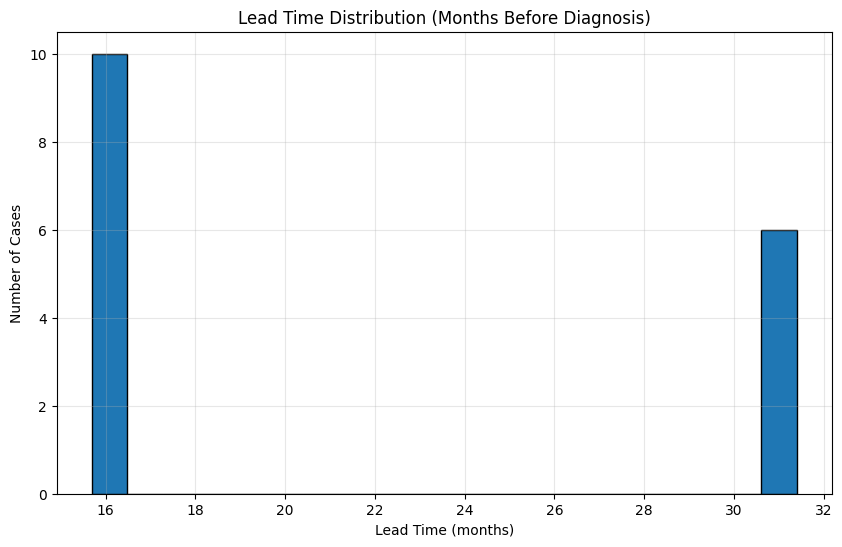

In [ ]:
# Run lead time analysis
lead_times = evaluate_lead_time(df, mci_ad_models, progression_type='MCI')

# Analyze results
if len(lead_times) == 0:
    print("No lead times calculated. Check if:")
    print("- Any patients actually progressed")
    print("- Models made any predictions above threshold")
else:
    # Convert to months (if your time was in months)
    mean_lead_months = np.mean(lead_times)
    median_lead_months = np.median(lead_times)
    positive_predictions = sum(lt > 0 for lt in lead_times) / len(lead_times)
    
    print(f"\nLead Time Analysis Results (MCI Progression):")
    print(f"Mean lead time: {mean_lead_months:.1f} months")
    print(f"Median lead time: {median_lead_months:.1f} months")
    print(f"Percentage predicted early: {positive_predictions*100:.1f}%")
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(lead_times, bins=20, edgecolor='black')
    plt.title("Lead Time Distribution (Months Before Diagnosis)")
    plt.xlabel("Lead Time (months)")
    plt.ylabel("Number of Cases")
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
saved_models_path = 'saved_models'

def load_model_components():
    """Load all model components (model, scaler, imputer) for each visit"""
    models_dict = {}
    
    for file_name in os.listdir(saved_models_path):
        if "MCI_AD_model_AD" in file_name:  # For MCI progression models
            try:
                visit_number = int(file_name.split("visit")[0])
                base_name = file_name.replace("_model_AD.pkl", "")
                
                # Load model
                model = joblib.load(os.path.join(saved_models_path, file_name))
                
                # Load scaler and imputer
                scaler = joblib.load(os.path.join(saved_models_path, f"{base_name}_scaler_AD.pkl"))
                imputer = joblib.load(os.path.join(saved_models_path, f"{base_name}_imputer_AD.pkl"))
                
                # Store components
                models_dict[visit_number] = {
                    'model': model,
                    'scaler': scaler,
                    'imputer': imputer,
                    'features': model.feature_names_in_  # Get features from the model
                }
                
            except Exception as e:
                print(f"Error loading {file_name}: {str(e)}")
                continue
    
    print(f"Successfully loaded models for visits: {list(models_dict.keys())}")
    return models_dict

# Load all model components
mci_ad_models = load_model_components()

Successfully loaded models for visits: [2, 3, 4, 5, 6]


In [ ]:
df = pd.read_csv('Dataset_1/ad_progressors.csv')
df = add_time_dimension(df, months_between_visits=15.7)

# Verify time column was added
print("Data with time dimension:")
print(df[['ID', 'Progression', 'months_since_baseline']].head())